In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
import sys
from pathlib import Path
from typing import List

import parselmouth
import matplotlib.pyplot as plt
import noisereduce as nr
import numpy as np
import opensmile
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import torchaudio
from ipywidgets import GridspecLayout, Output
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler
from tqdm.auto import tqdm

sys.path.append("..")
from IPython.display import Audio, display

from sgs_utils.data_filtering import get_valid_audio_mask
from sgs_utils.path_conf import (
    interim_speech_data_dir,
    loc_data_dir,
    speech_data_session_dir,
)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
sns.set_context("talk")
sns.set_style("whitegrid")

# https://pytorch.org/audio/stable/backend.html#module-torchaudio.backend
torchaudio.get_audio_backend()

import torch
from speechbrain.pretrained import VAD

from sgs_utils.speech_analysis import whole_duration_image


In [3]:
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot_cleaned.parquet"))

# load the model
VAD_model = VAD.from_hparams(
    source="speechbrain/vad-crdnn-libriparty", savedir=".vad_model"
)

smile_lld = opensmile.Smile(
    # feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
# feat_cols = ["F0semitoneFrom27.5Hz_sma3nz", "jitterLocal_sma3nz"]
feat_cols = ["F0final_sma", "voicingFinalUnclipped_sma"]


In [4]:
from sgs_utils.speech_analysis import analyze_utterance
from sgs_utils.data_filtering import _silent_recording_mask

df_silent_sessions = df_session[_silent_recording_mask(df_session)]


In [5]:
def get_pitch_params(snd):
    pitch = snd.to_pitch()
    xs = pitch.xs()
    pitch_arr = pitch.selected_array["frequency"]
    pitch_strength_arr = pitch.selected_array["strength"]
    return xs, pitch_arr, pitch_strength_arr


In [8]:
# soi = df_session[(df_session.ID == "8f42a931-7bd1-4536-bec3-a5f24da3c61f")].iloc[0]
soi = df_session.sample(1).iloc[0]
wav_path_orig = list(
    speech_data_session_dir.glob(f"*{soi.ID}/{soi.DB}/*{soi.time_str}*")
)[0]
wav_path_16khz = list(
    interim_speech_data_dir.glob(f"full_dur_16khz/{soi.ID}/{soi.DB}/*{soi.time_str}*")
)[0]


noise_factor = 1 / 2**8

arr_orig_wav_n, fs_orig = torchaudio.load(wav_path_orig, normalize=True)
arr_orig_wav_n = arr_orig_wav_n.numpy().ravel()
arr_16khz_n, fs = (
    np.load(wav_path_16khz.parent / (wav_path_16khz.stem + ".npy")).ravel(),
    16_000,
)
t_arr_n = np.arange(0, arr_16khz_n.shape[0]) / fs
noise = (np.random.rand(len(arr_16khz_n)) * noise_factor).astype(np.float32)
arr_16khz_n_noisy = arr_16khz_n + noise
noise = (np.random.rand(len(arr_orig_wav_n)) * noise_factor).astype(np.float32)
arr_orig_wav_n_noisy = arr_orig_wav_n + noise
t_arr_orig_n = np.arange(arr_orig_wav_n.shape[0]) / fs_orig

def to_st(Hz: np.array) -> np.array:
    Hz[Hz == 0] = 27.5
    return np.log(Hz / 27.5) / np.log(2 ** (1 / 12))



xs_orig, pitch_orig, strength_orig = get_pitch_params(
    parselmouth.Sound(str(wav_path_orig))
)
xs_16k, pitch_16k, strength_16k = get_pitch_params(
    parselmouth.Sound(str(wav_path_16khz))
)
xs_orig_noise, pitch_orig_noise, strength_orig_noise = get_pitch_params(
    parselmouth.Sound(arr_orig_wav_n_noisy, sampling_frequency=fs_orig)
)
xs_16k_noise, pitch_16k_noise, strength_16k_noise = get_pitch_params(
    parselmouth.Sound(arr_16khz_n_noisy, sampling_frequency=16_000)
)

pitch_orig = to_st(pitch_orig)
pitch_orig_noise = to_st(pitch_orig_noise)
pitch_16k = to_st(pitch_16k)
pitch_16k_noise = to_st(pitch_16k_noise)


fr = analyze_utterance(
    # Low quality session -> a lot of noise
    #   => opensmile cannot qualitatively extract features
    utterance=soi,
    plot=True,
    feat_cols=["F0semitoneFrom27.5Hz_sma3nz"],
    norm_audio=False,
    audio=False,
    vad=True,
    noise_reduction=False,
    show_corr=False,
    plot_type="return",
)

# Add the pitch and pitch strength
fr.add_trace(
    {"name": "praat orig", "x": xs_orig, "y": pitch_orig, "mode": "lines"},
    row=2,
    col=1,
    # secondary_y=True,
)
fr.add_trace(
    {"name": "praat 16khz", "x": xs_16k, "y": pitch_16k, "mode": "lines"},
    row=2,
    col=1,
    # secondary_y=True,
)
fr.add_trace(
    {
        "name": "praat orig noise",
        "x": xs_orig_noise,
        "y": pitch_orig_noise,
        "mode": "lines",
    },
    row=2,
    col=1,
    # secondary_y=True,
)
fr.add_trace(
    {
        "name": "praat 16khz noise",
        "x": xs_16k_noise,
        "y": pitch_16k_noise,
        "mode": "lines",
    },
    row=2,
    col=1,
    # secondary_y=True,
)
# fr.add_trace(
#     {'name': 'strength praat', 'x': xs, 'y': pitch_strength_arr, 'mode': 'lines'},
#     row=3, col=1, secondary_y=True
# )
fr.update_layout(height=800)
fr.show_dash(mode="inline", port=8037)


age-sex: 25 - female		education: unif		device: pc-mic


/tmp/ipykernel_3249560/2592384951.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')


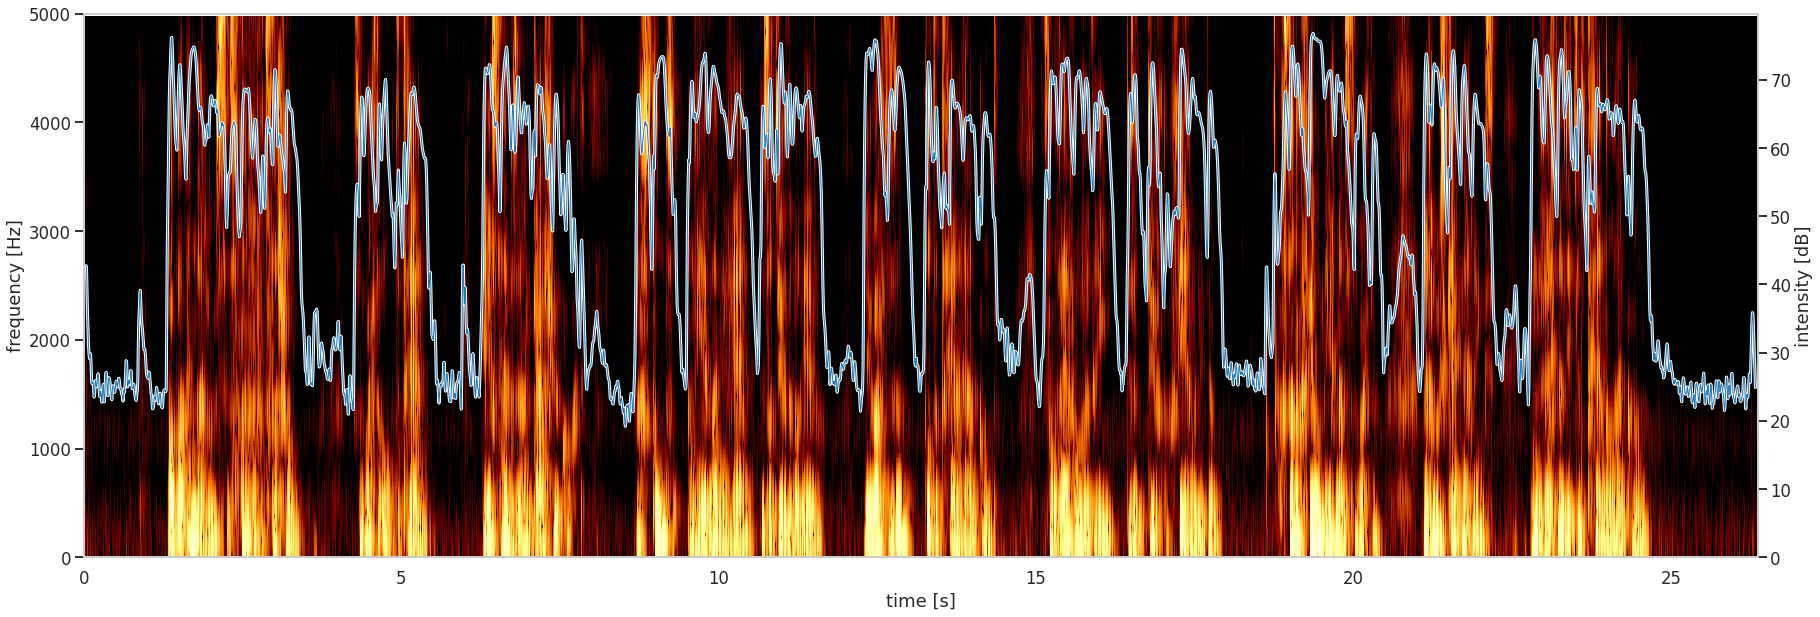

In [31]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap="afmhot")
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")


def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color="w")
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")


intensity = snd.to_intensity()
spectrogram = snd.to_spectrogram()
plt.figure(figsize=(30, 10))
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show()


In [34]:
# This is the function to measure source acoustics using default male parameters.
from parselmouth.praat import call


def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID)  # read the sound
    duration = call(sound, "Get total duration")  # duration
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max)  # create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit)  # get mean pitch
    stdevF0 = call(
        pitch, "Get standard deviation", 0, 0, unit
    )  # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, f0min, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(
        pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3
    )
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer = call(
        [sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6
    )
    localdbShimmer = call(
        [sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6
    )
    apq3Shimmer = call(
        [sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6
    )
    aqpq5Shimmer = call(
        [sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6
    )
    apq11Shimmer = call(
        [sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6
    )
    ddaShimmer = call(
        [sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6
    )

    return {
        "duration": duration,
        "meanF0": meanF0,
        "stdevF0": stdevF0,
        "hnr": hnr,
        "localJitter": localJitter,
        "localabsoluteJitter": localabsoluteJitter,
        "rapJitter": rapJitter,
        "ppq5Jitter": ppq5Jitter,
        "ddpJitter": ddpJitter,
        "localShimmer": localShimmer,
        "localdbShimmer": localdbShimmer,
        "apq3Shimmer": apq3Shimmer,
        "aqpq5Shimmer": aqpq5Shimmer,
        "apq11Shimmer": apq11Shimmer,
        "ddaShimmer": ddaShimmer,
    }


In [35]:
measurePitch(str(orig_wav_path), 75, 300, "Hertz")


{'duration': 26.368,
 'meanF0': 112.64411251002218,
 'stdevF0': 14.240096581746046,
 'hnr': 10.695543772412043,
 'localJitter': 0.030754462482274675,
 'localabsoluteJitter': 0.000273138675387056,
 'rapJitter': 0.014139328128700368,
 'ppq5Jitter': 0.01740498648631917,
 'ddpJitter': 0.0424179843861011,
 'localShimmer': 0.15121904836785283,
 'localdbShimmer': 1.3980695191686752,
 'apq3Shimmer': 0.05760782767730087,
 'aqpq5Shimmer': 0.08810295759710146,
 'apq11Shimmer': 0.1768567814995292,
 'ddaShimmer': 0.1728234830319026}